In [1]:
#!pip install CommonRegex
#!pip install pgeocode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pytesseract 
from PIL import Image, ImageOps
import re
from commonregex import CommonRegex
import pgeocode

texts_df = pd.read_csv('texts.csv')


In [35]:
print(texts_df['0'][0])

    
  
  
  

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(S62) 597-0906

Server: Francis Station: 4
Order #: 69923 Dine In
Table: B11 Guests: 2
1 Coffee 3.00
2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1:

TOTAL: $56.58

5/26/2016 12:53:10 PM

INAH

THANK YOU!

 



In [3]:
#Change this function to extract ITEMS (with their respective prices)
"""After geting the prices, locate their boxes, search for boxes that have similar height, assume those are 
the names of the items. Then look for the largest box (or the box on top), assume those are the names of the shops). """

def extract_prices(text):
    prices = CommonRegex(text).prices
    if len(prices) > 1:
        return prices
    else:
        return np.nan
    
    
    return CommonRegex(text).prices

In [4]:
def extract_geo(text):
    #zip_code 
    us_zip = r'(\d{5}\-?\d{0,4})'
    zip_code = re.search(us_zip, text)
    try:
        zip_code = zip_code[0]
        nomi = pgeocode.Nominatim('us')
        geodata = nomi.query_postal_code(zip_code)
        longitude = geodata['longitude']
        latitude = geodata['latitude']
    except:
        zip_code = np.nan
        longitude = np.nan
        latitude = np.nan
        
    
    address = CommonRegex(text).street_addresses
    if len(address) == 1:
        address =  address[0]
    else:
        address = np.nan

        
    return zip_code, longitude, latitude, address
    
    

In [5]:
def extract_time(text):
    times = CommonRegex(text).times
    if len(times) == 1:
        return times[0]
    else:
        return np.nan

In [6]:
#texts_df = pd.read_csv('texts.csv')
geos = []
times = []
for text in texts_df['0']:
    times.append(extract_time(text))
    geos.append(extract_geo(text))



In [7]:
df = pd.DataFrame(data = geos, columns = ['Zipcode','Latitude', 'Longitude', 'Address' ])
df['Time'] = times

In [8]:
prices = []
for text in texts_df['0']:
    prices.append(extract_prices(text))
df['prices'] = prices


database = df.explode('prices')
database.reset_index(inplace = True)

In [47]:
database.head()

,index,Zipcode,Latitude,Longitude,Address,Time,prices
0,0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,12:53,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,378752,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,11:19 AM,$8.39


<AxesSubplot:>

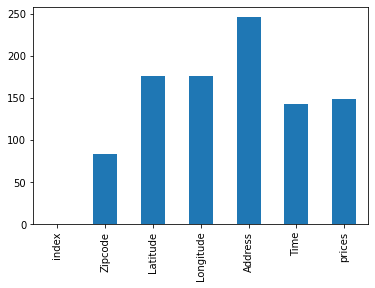

In [9]:
database.isna().sum().plot(kind = 'bar')

<AxesSubplot:>

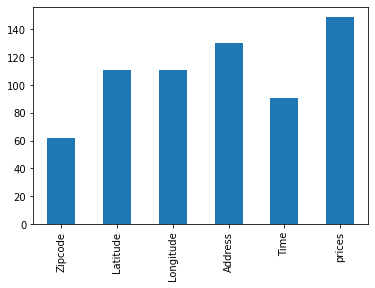

In [10]:
df.isna().sum().plot(kind = 'bar')

In [13]:
def extract_text(url):
    import pytesseract 
    from PIL import Image
    
    """extracts test out of image
    --inputs= image_url """
    #opening the image
    im=Image.open(url)
    grey= im.convert(mode="L")
    #threshold= 160
    #image=grey.point(lambda x: 255 if x > threshold else 0)
    
    #configuration for pytesseract to operate with text extraction
    config = ('-l eng --oem 1 --psm 3')
    text = pytesseract.image_to_string(grey, config=config)
    
    return text

In [32]:
import pytesseract 
from PIL import Image

"""extracts test out of image
--inputs= image_url """

url=(r"images/large-receipt-image-dataset-SRD/1000-receipt.jpg")

#opening the image
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
im=Image.open(url)
grey= im.convert(mode="L")
#threshold= 160
#image=grey.point(lambda x: 255 if x > threshold else 0)

#configuration for pytesseract to operate with text extraction

config = ('-l eng --oem 1 --psm 3')
text = pytesseract.image_to_string(grey, config=config)

boxes = pytesseract.image_to_data(im,output_type=pytesseract.Output.DATAFRAME)



,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,750,1000,-1.000000,NaN
1,2,1,1,0,0,0,0,6,660,994,-1.000000,NaN
2,3,1,1,1,0,0,0,6,660,994,-1.000000,NaN
3,4,1,1,1,1,0,0,6,660,317,-1.000000,NaN
4,5,1,1,1,1,1,0,6,660,317,95.000000,
...,...,...,...,...,...,...,...,...,...,...,...,...
85,2,1,8,0,0,0,334,885,121,23,-1.000000,NaN
86,3,1,8,1,0,0,334,885,121,23,-1.000000,NaN
87,4,1,8,1,1,0,334,885,121,23,-1.000000,NaN
88,5,1,8,1,1,1,334,885,61,22,96.782433,THANK


In [41]:
boxes[boxes['text'] == '3.00']

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
53,5,1,4,1,3,3,594,544,48,19,89.818146,3.00
61,5,1,4,1,5,3,596,601,48,19,91.515167,3.00


In [42]:
boxes[boxes['text'] == 'Coffee']

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
52,5,1,4,1,3,2,192,539,68,19,88.761948,Coffee


In [45]:
boxes.block_num.value_counts()

4    33
2    19
1    10
3     7
6     6
5     5
8     5
7     4
0     1
Name: block_num, dtype: int64